In [1]:
filenames = [
    "GSM4909255_N-N280-Epi.h5ad",
    "GSM4909256_N-PM0095-Epi.h5ad",
    "GSM4909258_N-NF-Epi.h5ad",
    "GSM4909259_N-NE-Epi.h5ad",
    "GSM4909260_N-N1105-Epi.h5ad",
    "GSM4909262_N-MH0064-Epi.h5ad",
    "GSM4909264_N-N1B-Epi.h5ad",
    "GSM4909267_N-MH0023-Epi.h5ad",
    "GSM4909269_N-PM0342-Epi.h5ad",
    "GSM4909273_N-MH275-Epi.h5ad",
    "GSM4909275_N-PM0372-Epi.h5ad",
]

In [2]:
from signals_in_the_noise.preprocessing.gse161529 import GSE161529

gse = GSE161529()

2025-07-07 22:19:28,757 [INFO] signals_in_the_noise.utilities.tenx_genomics: Reading C:\Users\silly\GitHub\signals-in-the-noise\data\GSE161529_adata_cache\GSM4909253_N-PM0092-Total.h5ad as AnnData object.
2025-07-07 22:19:29,026 [INFO] signals_in_the_noise.utilities.tenx_genomics: Reading C:\Users\silly\GitHub\signals-in-the-noise\data\GSE161529_adata_cache\GSM4909254_N-PM0019-Total.h5ad as AnnData object.
2025-07-07 22:19:29,217 [INFO] signals_in_the_noise.utilities.tenx_genomics: Reading C:\Users\silly\GitHub\signals-in-the-noise\data\GSE161529_adata_cache\GSM4909255_N-N280-Epi.h5ad as AnnData object.
2025-07-07 22:19:29,409 [INFO] signals_in_the_noise.utilities.tenx_genomics: Reading C:\Users\silly\GitHub\signals-in-the-noise\data\GSE161529_adata_cache\GSM4909256_N-PM0095-Epi.h5ad as AnnData object.
2025-07-07 22:19:29,800 [INFO] signals_in_the_noise.utilities.tenx_genomics: Reading C:\Users\silly\GitHub\signals-in-the-noise\data\GSE161529_adata_cache\GSM4909257_N-PM0095-Total.h5ad 

In [3]:
# adata

In [4]:
adata = gse.objects[filenames[0]]
adata = adata[adata.obs['is_noise'] == 1].copy()

In [5]:
'CD49f' in adata.var_names

False

In [6]:
adata.obs["ITGA6_EXPR"] = adata[:, "ITGA6"].X.toarray().flatten()
adata.obs["EPCAM_EXPR"] = adata[:, "EPCAM"].X.toarray().flatten()

In [7]:
from sklearn.mixture import GaussianMixture

def classify_gmm(expression_array):
    gmm = GaussianMixture(n_components=2).fit(expression_array.reshape(-1, 1))
    labels = gmm.predict(expression_array.reshape(-1, 1))
    means = gmm.means_.flatten()
    return labels if means[1] < means[0] else 1 - labels

adata.obs["ITGA6_GMM"] = classify_gmm(adata.obs["ITGA6_EXPR"].values)
adata.obs["EPCAM_GMM"] = classify_gmm(adata.obs["EPCAM_EXPR"].values)

In [8]:
def classify_gmm(row):
    if row["ITGA6_GMM"] == 1 and row["EPCAM_GMM"] == 0:
        return "Basal"
    elif row["ITGA6_GMM"] == 1 and row["EPCAM_GMM"] == 1:
        return "Luminal progenitor"
    elif row["ITGA6_GMM"] == 0 and row["EPCAM_GMM"] == 1:
        return "Mature luminal"
    else:
        return "Other"

adata.obs["FACS_LIKE_GMM"] = adata.obs.apply(classify_gmm, axis=1)

C:\Users\silly\GitHub\signals-in-the-noise\.venv\Lib\site-packages\scanpy\preprocessing\_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
... storing 'FACS_LIKE_GMM' as categorical


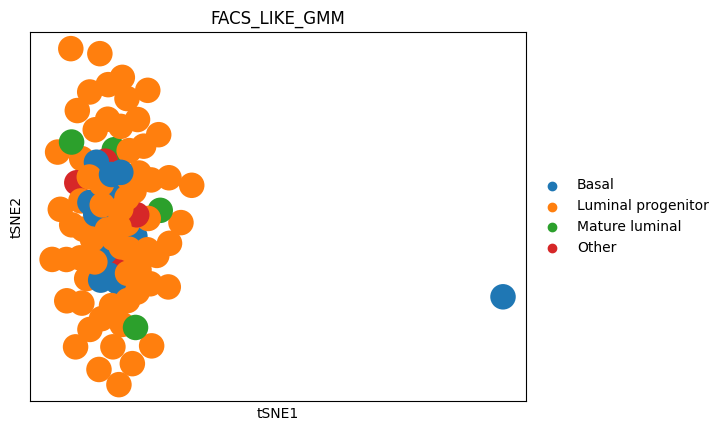

In [9]:
import scanpy as sc

# Example: start with a raw AnnData object `adata`
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)
adata = adata[:, adata.var['highly_variable']]  # subset to HVGs
sc.pp.scale(adata)

# PCA before t-SNE is recommended
sc.tl.pca(adata, n_comps=50)
sc.tl.tsne(adata, n_pcs=50, perplexity=30)
sc.pl.tsne(adata, color='FACS_LIKE_GMM')